In [1]:
import rasterio 
import numpy as np
import h5py
import os
import cv2
import random
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 5, 5

In [2]:
def addCloudMaskOverData(data, mask):
    maskedData = np.copy(data)
    maskedData[mask == 0] = 0
    return maskedData

In [3]:
def readTifImage(file_name):
    data = rasterio.open(file_name, 'r').read(1)
    if (data.max() == 255):
        # Mask max 255, normal max 65535
        data //= 255
    return data

In [36]:
def getSamplingArray(img, img2, sz, n):
    nr, nc = img.shape
    data = np.zeros((n, sz, sz), dtype=img.dtype)
    data2 = np.zeros((n, sz, sz), dtype=img2.dtype)
    for i in range(n):
        r = random.randint(0, nr-sz)
        c = random.randint(0, nc-sz)
        data[i,:,:] = img[r:r+sz,c:c+sz]
        data2[i,:,:] = img2[r:r+sz,c:c+sz]
    return data, data2

In [5]:
for root, folders, files in os.walk('dataset/CloudFree/'):
    break
listInput = folders

for __, _, files in os.walk('dataset/CloudMaskExamples/'):
    break
listMask = files

In [6]:
bandDef = ['B3', 'B4', 'B5', 'B6']

In [26]:
# Shuffle Referenced Images
nTrain = len(listInput)
nMask = len(listMask)

refImg = np.copy(listInput)
np.random.shuffle(refImg)

nBands = len(bandDef)
imgSize = 400
nTimes = 30

lLabel = np.zeros((nMask*nTrain*nTimes*nBands,imgSize,imgSize,1),dtype=np.uint16)
lMasked = np.zeros((nMask*nTrain*nTimes*nBands,imgSize,imgSize,1),dtype=np.uint16)
lRef = np.zeros((nMask*nTrain*nTimes*nBands,imgSize,imgSize,1),dtype=np.uint16)
lMask = np.zeros((nMask*nTrain*nTimes*nBands,imgSize,imgSize,1),dtype=np.uint16)

In [37]:
p = -1

for j in range(nMask):
    mask = readTifImage(os.path.join('dataset', 'CloudMaskExamples', listMask[j]))
    
    for i in range(nTrain):
        dLabel = np.zeros((nTimes*nBands,imgSize,imgSize),dtype='uint16')
        dMasked = np.zeros((nTimes*nBands,imgSize,imgSize),dtype='uint16')
        dRef = np.zeros((nTimes*nBands,imgSize,imgSize),dtype='uint16')
        
        # Read for each bands
        for b in range(nBands):
            label = readTifImage(os.path.join(root, listInput[i], listInput[i] + '_' + bandDef[b] + '.TIF'))
            ref = readTifImage(os.path.join(root, refImg[i], refImg[i] + '_' + bandDef[b] + '.TIF'))
            dLabel[b*nTimes:(b+1)*nTimes,:,:], dRef[b*nTimes:(b+1)*nTimes,:,:] = getSamplingArray(label, ref, imgSize, nTimes)
                        
            for j in range(nTimes):
                masked = addCloudMaskOverData(data=dLabel[b*nTimes+j,:,:],mask=mask)           
                dMasked[b*nTimes+j,:,:] = masked
        
        for j in range(dLabel.shape[0]):
            p += 1
            lLabel[p,:,:,0] = dLabel[j,:,:]
            lMasked[p,:,:,0] = dMasked[j,:,:]
            lRef[p,:,:,0] = dRef[j,:,:]
            lMask[p,:,:,0] = mask[:,:]

/home/anhldt/.local/lib/python3.5/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


In [ ]:
f = h5py.File('dataset_noresize.hdf5', 'w')
f.create_dataset('label',data=lLabel)
f.create_dataset('ref',data=lRef)
f.create_dataset('masked',data=lMasked)
f.create_dataset('mask',data=lMask)
f.close()

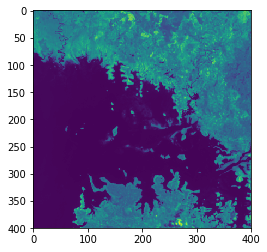

In [38]:
plt.imshow(lLabel[1079,:,:,0])

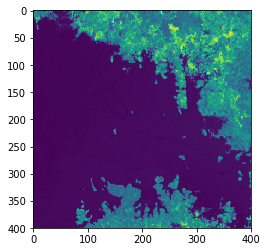

In [39]:
plt.imshow(lRef[1079,:,:,0])